In [1]:
import numpy as np
import os
import subprocess
import theano

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11254009917538055173
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1436473753
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1438412614901041522
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [ ]:
#!pip install --upgrade utils

#import sys
#!conda install --yes --prefix {sys.prefix} theano

#import sys
#!conda install --yes --prefix {sys.prefix} keras

#import sys
#!{sys.executable} -m pip install --upgrade keras

#!pip uninstall keras
#!pip install keras --upgrade

# Current stable release for CPU and GPU
#!pip install --upgrade tensorflow

#import sys
#!conda install --yes --prefix {sys.prefix} tensorflow-gpu

#import sys
#!conda install --yes --prefix {sys.prefix} scipy

In [2]:
TRAIN_PATH = 'secondary_proteins_presubprocesson/data/cullpdb+profile_6133_filtered.npy.gz'
TEST_PATH = 'secondary_proteins_prediction/data/cb513+profile_split1.npy.gz'

In [3]:
def load_gz(path):  # load a .npy.gz file
    if path.endswith(".gz"):
        f = open(path, 'rb')
        return np.load(f)
    else:
        return np.load(path)

In [4]:
##### TRAIN DATA #####

def get_train(path=TRAIN_PATH):
    if not os.path.isfile(path):
        print("Train path is not downloaded ...")
        subprocess.call("./download_train.sh", shell=True)
    else:
        print("Train path is downloaded ...")
    print("Loading train data ...")
    X_in = load_gz(path)
    X = np.reshape(X_in, (5534, 700, 57))
    del X_in
    X = X[:, :, :]
    labels = X[:, :, 22:30]
    mask = X[:, :, 30] * -1 + 1

    a = np.arange(0, 21)
    b = np.arange(35, 56)
    c = np.hstack((a, b))
  #  X = X[:, :, c]
    
    # getting meta
    num_seqs = np.size(X, 0)
    seqlen = np.size(X, 1)
    d = np.size(X, 2)
    num_classes = 8

    #### REMAKING LABELS ####
    X = X.astype(theano.config.floatX)
    mask = mask.astype(theano.config.floatX)
    # Dummy -> concat
    vals = np.arange(0, 8)
    labels_new = np.zeros((num_seqs, seqlen))
    for i in range(np.size(labels, axis=0)):
        labels_new[i, :] = np.dot(labels[i, :, :], vals)
    labels_new = labels_new.astype('int32')
    labels = labels_new
    print(labels.shape)

    print("Loading splits ...")
    ##### SPLITS #####
    # getting splits (cannot run before splits are made)
    # split = np.load("data/split.pkl")

    seq_names = np.arange(0, num_seqs)
    # np.random.shuffle(seq_names)

    X_train = X[seq_names[0:5278]]
    X_valid = X[seq_names[5278:5534]]
    labels_train = labels[seq_names[0:5278]]
    labels_valid = labels[seq_names[5278:5534]]
    mask_train = mask[seq_names[0:5278]]
    mask_valid = mask[seq_names[5278:5534]]
    num_seq_train = np.size(X_train, 0)
    num_seq_valid = np.size(X_valid, 0)
    return X_train, X_valid, labels_train, labels_valid, mask_train, \
           mask_valid, num_seq_train

In [5]:
TRAIN_PATH = 'secondary_proteins_prediction/data/cullpdb+profile_6133_filtered.npy.gz'
X_train, X_valid, labels_train, labels_valid, mask_train, mask_valid, _ = get_train(TRAIN_PATH)
print("Done loading train")
print(X_train.shape)

Train path is downloaded ...
Loading train data ...
(5534, 700)
Loading splits ...
Done loading train
(5278, 700, 57)


In [6]:
def get_test(path=TEST_PATH):
    if not os.path.isfile(path):
        subprocess.call("./download_test.sh", shell=True)
    print("Loading test data ...")
    X_test_in = load_gz(path)
    X_test = np.reshape(X_test_in, (514, 700, 57))
    del X_test_in
    X_test = X_test[:, :, :].astype(theano.config.floatX)
    labels_test = X_test[:, :, 22:30].astype('int32')
    mask_test = X_test[:, :, 30].astype(theano.config.floatX) * -1 + 1

    a = np.arange(0, 21)
    b = np.arange(35, 56)
    c = np.hstack((a, b))
   #X_test = X_test[:, :, c]

    # getting meta
    seqlen = np.size(X_test, 1)
    d = np.size(X_test, 2)
    num_classes = 8
    num_seq_test = np.size(X_test, 0)
    del a, b, c

    ## DUMMY -> CONCAT ##
    vals = np.arange(0, 8)
    labels_new = np.zeros((num_seq_test, seqlen))
    for i in range(np.size(labels_test, axis=0)):
        labels_new[i, :] = np.dot(labels_test[i, :, :], vals)
    labels_new = labels_new.astype('int32')
    labels_test = labels_new

    ### ADDING BATCH PADDING ###

    X_add = np.zeros((126, seqlen, d))
    label_add = np.zeros((126, seqlen))
    mask_add = np.zeros((126, seqlen))

    X_test = np.concatenate((X_test, X_add), axis=0).astype(theano.config.floatX)
    labels_test = np.concatenate((labels_test, label_add), axis=0).astype('int32')
    mask_test = np.concatenate((mask_test, mask_add), axis=0).astype(theano.config.floatX)
    return X_test, mask_test, labels_test, num_seq_test

In [7]:
TEST_PATH = 'secondary_proteins_prediction/data/cb513+profile_split1.npy.gz'
X_test, mask_test, labels_test, num_seq_test = get_test(TEST_PATH)
print("Done loading test")
print(X_test.shape)

Loading test data ...
Done loading test
(640, 700, 57)


In [8]:
#To do: Make 1 hot encoded class - from Q8 to Q3
       #Reshape the dataset so it has 700*windowSize seq that map to a class
       #Look inside lasagne to see how we disregard the padding
##

def q8ClassToQ3(q8Labels):
    
    q3 = np.zeros(3)
    index = np.argmax(q8Labels)
    
    #Helix
    if index == 5 or index == 3 or index == 4 : # H ,G, I
        q3[0] = 1   
    #beta    
    if index == 1 or index == 2: # B, E
        q3[1] = 1    
    #coil    
    if index == 7 or index == 6 or index == 0 : # T, S, L
        q3[2] = 1
    return q3

def q8ClassToQ2(q8Labels):
    
    q2 = np.zeros(2)
    index = np.argmax(q8Labels)
 
    #Helix
    if index == 5: # or index == 3 or index == 4 : # H ,G, I
        q2[0] = 1
    else:
        q2[1] = 1  
    return q2

def changeQ8Class(dataSet, reductionFunction, numberOfFeatures):

    num_seqs = np.size(dataSet, 0)
    seqlen = np.size(dataSet, 1)
    labels_new = np.zeros((num_seqs, seqlen, numberOfFeatures))

    for i in range(np.size(dataSet, axis=0)):
        for j in range(np.size(dataSet, axis=1)):
            oneHot = reductionFunction(dataSet[i, j, 22:30])
            features = np.concatenate((dataSet[i, j, 0:21], oneHot), axis=None)
            features = np.concatenate((features, dataSet[i, j, 35:56]), axis=None)
            labels_new[i][j] = features
    return labels_new


In [9]:
def swapClassLabel(features, classLabel, classSize):

    res = np.concatenate((features[0:21], classLabel), axis=None)
    res = np.concatenate((res, features[ (21+classSize) :]), axis=None)
  
    return res

In [10]:
import math

#num_classes should be q8, q3 or maybe q2?
def proteinSequenceToWindowSequence(windowSize, predictionIndex , dataSet, classSize):
   
    num_seqs = np.size(dataSet, 0)
    seqlen = np.size(dataSet, 1)
    features = np.size(dataSet, 2)
    dataSet_new = np.zeros((num_seqs, seqlen - windowSize + 1, windowSize, features))
    
    for i in range(np.size(dataSet, axis=0)):
        if i % 100 == 0:
            print(i)
        for j in range(np.size(dataSet, axis=1) - windowSize + 1):
            classLabel = dataSet[i][j + predictionIndex][21 : (21+classSize) ]
            for k in range(windowSize):
                dataSet_new[i][j][k] = swapClassLabel(dataSet[i][j+k], classLabel, classSize)
            
    return dataSet_new    

In [11]:
def removeWindowsWithPadding(dataSet, windowSize, numberOfFeatures):
    
    dataSet = np.reshape(dataSet, (dataSet.shape[0]*dataSet.shape[1], windowSize, numberOfFeatures))
    dataSet = dataSet[np.count_nonzero( dataSet, axis=(1,2))>(int(windowSize/2)*numberOfFeatures), :, :] 
    
    return dataSet

In [12]:
windowSize = 19
predictionIndex = 8
classSize = 2  # 2 or 3 
numberOfFeatures = 44

In [13]:
print(X_train.shape)
X_train = changeQ8Class(X_train, q8ClassToQ2, numberOfFeatures)
print(X_train.shape, "changed train data to class of size ", classSize)
X_train_window = proteinSequenceToWindowSequence(windowSize,predictionIndex, X_train, classSize)
print(X_train_window.shape, "changed train data  to window sequence of size ", windowSize)
X_train_window = removeWindowsWithPadding(X_train_window , windowSize, numberOfFeatures)
print(X_train_window.shape, "filtered windows withouth padding of train data ")

print(X_valid.shape)
X_valid = changeQ8Class(X_valid, q8ClassToQ2, numberOfFeatures)
print(X_valid.shape, "changed validation data to class size ", classSize)
X_valid_window = proteinSequenceToWindowSequence(windowSize,predictionIndex, X_valid, classSize)
print(X_valid_window.shape, "changed validation data to window sequence of size ", windowSize)
X_valid_window = removeWindowsWithPadding(X_valid_window , windowSize, numberOfFeatures)
print(X_valid_window.shape, "filtered windows withouth padding of validation data")


(5278, 700, 57)
(5278, 700, 44) changed train data to class of size  2
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
(5278, 682, 19, 44) changed train data  to window sequence of size  19
(1040146, 19, 44) filtered windows withouth padding of train data 
(256, 700, 57)
(256, 700, 44) changed validation data to class size  2
0
100
200
(256, 682, 19, 44) changed validation data to window sequence of size  19
(49104, 19, 44) filtered windows withouth padding of validation data


In [14]:
sequence_len = 700
amino_acid_residues = 21
num_classes = 2

In [15]:

x_train_final = X_train_window[:,:,0:21]
y_train_final = X_train_window[:,:,21 : (21+classSize)]
print(x_train_final.shape, "training data")
print(y_train_final.shape, "labels for training data")

x_valid_final = X_valid_window[:,:,0:21]
y_valid_final = X_valid_window[:,:,21 : (21+classSize)]
print(x_valid_final.shape, "validation data")
print(y_valid_final.shape, "labels for training validation")


(1040146, 19, 21) training data
(1040146, 19, 2) labels for training data
(49104, 19, 21) validation data
(49104, 19, 2) labels for training validation


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.regularizers import l2

LR = 0.0005
drop_out = 0.3
batch_dim = 64
nn_epochs = 10

loss = 'categorical_crossentropy'


m = Sequential()
m.add(Conv1D(128, 11, padding='same', activation='relu', input_shape=(windowSize, amino_acid_residues)))
m.add(Dropout(drop_out))
m.add(Conv1D(64, 11, padding='same', activation='relu'))
m.add(Dropout(drop_out))
m.add(Conv1D(num_classes, 11, padding='same', activation='softmax'))
opt = optimizers.Adam(lr=LR)
m.compile(optimizer=opt, loss=loss,metrics=['accuracy', 'mae'])

print("\nHyper Parameters\n")
print("Learning Rate: " + str(LR))
print("Drop out: " + str(drop_out))
print("Batch dim: " + str(batch_dim))
print("Number of epochs: " + str(nn_epochs))
print("\nLoss: " + loss + "\n")
m.summary()


Hyper Parameters

Learning Rate: 0.0005
Drop out: 0.3
Batch dim: 64
Number of epochs: 10

Loss: categorical_crossentropy

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 19, 128)           29696     
_________________________________________________________________
dropout (Dropout)            (None, 19, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 64)            90176     
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19, 2)             1410      
Total params: 121,282
Trainable params: 121,282
Non-trainable params: 0
___________________________________________________________

In [24]:
LR = 0.0009 # maybe after some (10-15) epochs reduce it to 0.0008-0.0007
drop_out = 0.38
batch_dim = 64

loss = 'categorical_crossentropy'

m = Sequential()
m.add(Conv1D(128, 5, padding='same', activation='relu', input_shape=(windowSize, amino_acid_residues)))
m.add(BatchNormalization())
m.add(Dropout(drop_out))
m.add(Conv1D(128, 3, padding='same', activation='relu'))
m.add(BatchNormalization())
m.add(Dropout(drop_out))
m.add(Conv1D(64, 3, padding='same', activation='relu'))
m.add(BatchNormalization())
m.add(Dropout(drop_out))
#m.add(Flatten())
m.add(Dense(128, activation='relu'))
m.add(Dense(32, activation='relu'))
m.add(Dense(num_classes, activation = 'softmax'))
opt = optimizers.Adam(lr=LR)
m.compile(optimizer=opt,
          loss=loss,
          metrics=['accuracy', 'mae'])

In [17]:
from time import time
from timeit import default_timer as timer

start_time = timer()
history = m.fit(x_train_final, y_train_final, epochs=nn_epochs, batch_size=batch_dim, validation_data=(x_valid_final, y_valid_final) ,shuffle=True)

end_time = timer()
print("\n\nTime elapsed: " + "{0:.2f}".format((end_time - start_time)) + " s")

Train on 1040146 samples, validate on 49104 samples
Epoch 1/10
1040146/1040146 [==============================] - 112s 107us/sample - loss: 0.4086 - accuracy: 0.8148 - mae: 0.2613 - val_loss: 0.3870 - val_accuracy: 0.8267 - val_mae: 0.2548
Epoch 2/10
1040146/1040146 [==============================] - 217s 209us/sample - loss: 0.3733 - accuracy: 0.8343 - mae: 0.2355 - val_loss: 0.3848 - val_accuracy: 0.8303 - val_mae: 0.2426
Epoch 3/10
1040146/1040146 [==============================] - 296s 284us/sample - loss: 0.3595 - accuracy: 0.8416 - mae: 0.2260 - val_loss: 0.3872 - val_accuracy: 0.8294 - val_mae: 0.2343
Epoch 4/10
1040146/1040146 [==============================] - 221s 213us/sample - loss: 0.3504 - accuracy: 0.8459 - mae: 0.2198 - val_loss: 0.3922 - val_accuracy: 0.8261 - val_mae: 0.2452
Epoch 5/10
1040146/1040146 [==============================] - 214s 206us/sample - loss: 0.3440 - accuracy: 0.8492 - mae: 0.2155 - val_loss: 0.3896 - val_accuracy: 0.8276 - val_mae: 0.2394
Epoch 6/

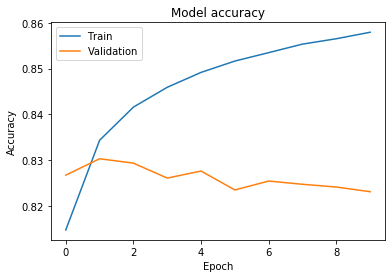

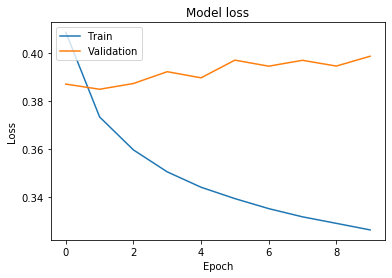

In [18]:
import matplotlib.pyplot as plt

accuracyName = 'accuracyMiddleQ2W19Real.png'
lossName = 'lossMiddleQ2W19Real.png'

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(accuracyName)
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(lossName)
plt.show()




In [19]:
import pickle


pickleName = "Q2Window19MMiddleReal.pickle"
pkl_filename = "Q2Window19MiddleReal.pkl"

pickle_out = open(pickleName,"wb")
pickle.dump(history, pickle_out)
pickle_out.close()


with open(pkl_filename, 'wb') as file:
    pickle.dump(m, file)

TypeError: can't pickle _thread.RLock objects

In [26]:
import pickle

# Save to file in the current working directory
pkl_filename = "Q2Window19MLeft.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(m, file)

TypeError: can't pickle _thread.RLock objects

In [20]:
X_test = changeQ8Class(X_test, q8ClassToQ2, numberOfFeatures)
X_test_window = proteinSequenceToWindowSequence(windowSize,predictionIndex, X_test, classSize)
X_test_window = removeWindowsWithPadding(X_test_window , windowSize, numberOfFeatures)
print(X_train_window.shape)

x_test_final = X_test_window[:,:,0:21]
y_test_final = X_test_window[:,:,21: (21+classSize)]
print(x_test_final.shape)
print(y_test_final.shape)

0
100
200
300
400
500
600
(1040146, 19, 44)
(76025, 19, 21)
(76025, 19, 2)


In [21]:
scores = m.evaluate(x_test_final, y_test_final)
print("Loss: " + str(scores[0]) + ", Accuracy: " + str(scores[1]) + ", MAE: " + str(scores[2]))

76025/76025 [==============================] - 8s 107us/sample - loss: 0.4027 - accuracy: 0.8260 - mae: 0.2350
Loss: 0.40266306587893963, Accuracy: 0.82595617, MAE: 0.23504974


In [26]:
print(history.history)

{'loss': [0.44966836823821205, 0.4156959092493396, 0.4030285179907845, 0.3947629566897908, 0.3889579159463983, 0.3844384876298406, 0.38121293385527116, 0.377806609109231, 0.3749496356954386, 0.37330466704874077], 'accuracy': [0.79195476, 0.81217813, 0.8187889, 0.82314277, 0.8261819, 0.82849085, 0.8299985, 0.8320786, 0.8331986, 0.83413166], 'mae': [0.29131523, 0.26585072, 0.25682375, 0.25105166, 0.24702397, 0.2439069, 0.24171908, 0.2393979, 0.23750165, 0.23633783], 'val_loss': [0.42621516084566147, 0.42289021183940245, 0.422474003301338, 0.42457270685858894, 0.4259774775361735, 0.42797773185014026, 0.4266078387459624, 0.4328603748682463, 0.4322029887590862, 0.43447310772945064], 'val_accuracy': [0.8056156, 0.8059125, 0.80789965, 0.806964, 0.8056692, 0.8068986, 0.80714935, 0.8028684, 0.8046917, 0.80294883], 'val_mae': [0.2793607, 0.27205122, 0.27998343, 0.27230123, 0.27273822, 0.27139467, 0.27769068, 0.2710833, 0.26690817, 0.2731029]}
